## _Processing Stage_

- examine the output of **Processing Stage** _e.g._ build event, plot true and false edges, etc.
- TODO: use _`SttTorchDataReader`_ to read processed events

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
sys.path.append("src")

In [6]:
# get cuda device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# local imports
from src import SttCSVDataReader, SttTorchDataReader
from src import Visualize_CSVEvent, Visualize_TorchEvent
from src import Build_Event, Build_Event_Viz, Visualize_Edges
from src import detector_layout
from src.math_utils import polar_to_cartesian

## _(1) - Config File_

In [8]:
# load processing config file (trusted source)
config_file = os.path.join(
    os.curdir, "LightningModules/data_processing/configs/prepare_quickstart.yaml"
)
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader)  # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [9]:
# change some params here
# config['n_files'] = 10

In [10]:
# see params used in this stage
# pp.pprint(config)

## _(2) - Load Data_

In [11]:
# select an event
event_id = 1

### _2.1 - SttCSVDataReader_

In [12]:
# use SttCSVDataReader
inputdir = "./data_all"
csv_reader = SttCSVDataReader(inputdir, noise=False, skewed=False, selection=False)
data = csv_reader(evtid=event_id)
event = data.event

In [13]:
# visualize CSVEvent
# Visualize_CSVEvent(event, figsize=(10,10), fig_type="pdf", save_fig=False)

### _2.2 - SttTorchDataReader_

In [14]:
# use SttTorchDataReader
inputdir = "./run/data_processing"
torch_reader = SttTorchDataReader(inputdir)
feature_data = torch_reader(evtid=event_id)

In [15]:
# visualize TorchEvent
# Visualize_TorchEvent(feature_data, figsize=(10,10), fig_type="pdf", save_fig=False)

In [16]:
# check datatypes of Data fields
# for key, value in feature_data:
#    print(f"{key}: {type(value)}")

- _`x, pid, layers, hid, pt, vertex, charge, pdgcode, petheta, peta`_ and _`pphi`_ should have same dimensions
- _`layerwise_true_edges, modulewise_true_edges`_ and _`orderwise_true_edges`_ can have different dimenisions from above and among themselves
- _`edge_index`_ and _`y_pid`_ should have same dimensions, since _`edge_index`_ is the input and _`y_pid`_ is the output given to neural network

## _(3) - Event Display_

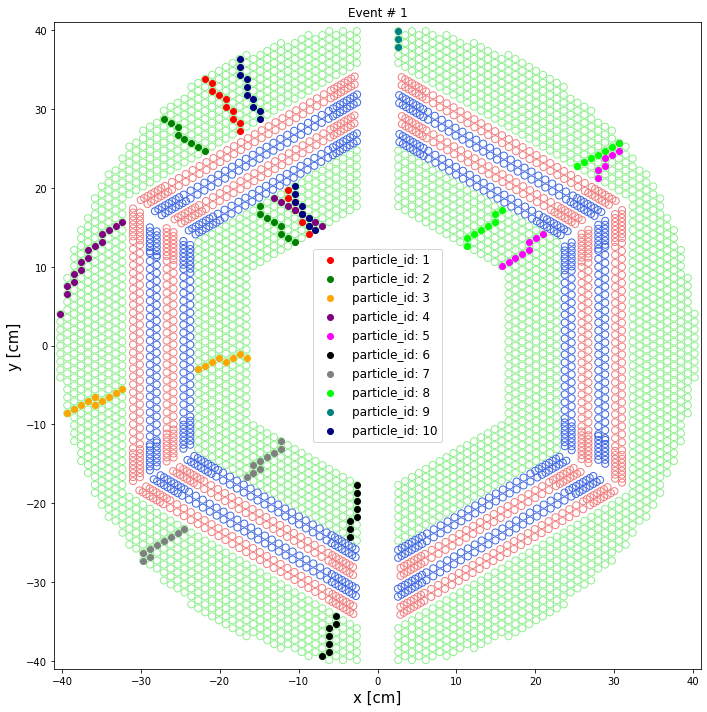

In [17]:
# visualize event
Visualize_TorchEvent(feature_data, figsize=(10, 10), fig_type="pdf", save_fig=False)

## _(4) - Plotting Edges_

- _True Edges (Layerwise, Modulewise, Orderwise)_
- _False Edges (Heuristic Method, Metric Learning)_
- _Input Edges (All True and False together)_

In [18]:
# select an event
event_id = 1

In [19]:
# use SttTorchDataReader to read an event
reader = SttTorchDataReader(inputdir)
feature_data = reader(evtid=event_id)

In [20]:
# examine the event
feature_data

Data(x=[159, 3], pid=[159], layers=[159], hid=[159], pt=[159], vertex=[159, 3], pdgcode=[159], ptheta=[159], peta=[159], pphi=[159], event_file='/export/home/adeel/current/ai4fair/ctstrkx/data_all/event0000000001', orderwise_true_edges=[2, 149], edge_index=[2, 1600], y_pid=[1600])

### _(4.1) - True Edges_

#### _(4.1.1.) - draw `true_edges` directly from `xxx_true_edges` fields from `feature_data`_

In [21]:
# get PyG data fields
x = feature_data.x
pids = feature_data.pid
e = feature_data.edge_index

In [22]:
# coordinate transform: [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

In [23]:
# get true edges
true_edges = feature_data.orderwise_true_edges
true_edges.shape

torch.Size([2, 149])

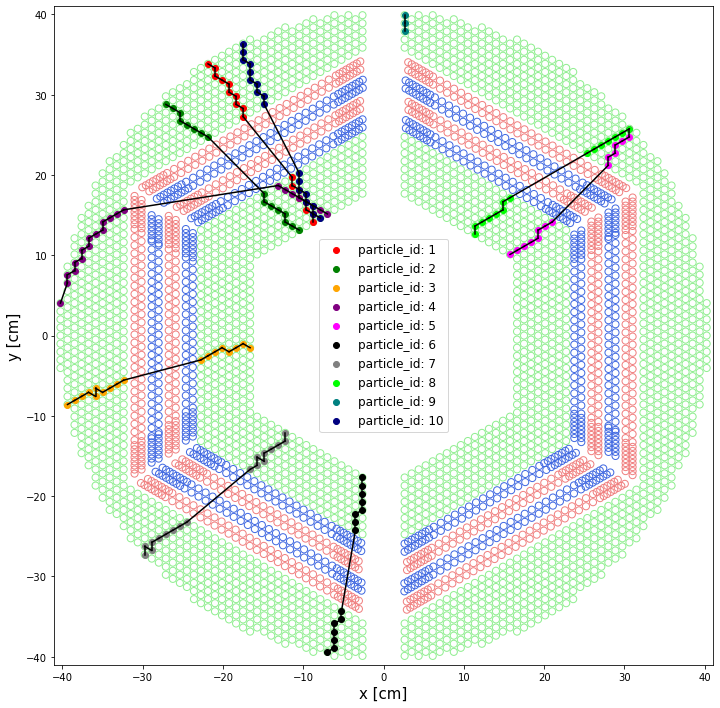

In [24]:
# Method 1: plotting ground truth directly from true_edges

plt.close("all")

# cmap = plt.get_cmap('tab20')
cmap = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "magenta",
    "black",
    "gray",
    "lime",
    "teal",
    "navy",
    "maroon",
    "olive",
    "indigo",
    "cyan",
]

# draw detector layout
fig, ax = detector_layout(figsize=(10, 10))

# draw particles
unique_pids = np.unique(pids)
for pid in unique_pids:
    mask = feature_data.pid == pid
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f"particle_id: {pid}")

# draw edges
ax.plot(x[true_edges], y[true_edges], c="k")

# for i, (source, target) in enumerate(true_edges.T):
# for (source, target) in true_edges.T:
#    ax.plot([x[source], x[target]], [y[source], y[target]], color='k')

# axis params
ax.legend(fontsize=12, loc="best")
fig.tight_layout()
fig.savefig("true_edges_1.pdf")

#### _(4.1.2.) - plotting `true_edges` from `edge_index` and `y` fields from `feature_data`_

In [25]:
# get PyG data fields
x = feature_data.x
pids = feature_data.pid
e = feature_data.edge_index
y_pid = feature_data.y_pid

In [26]:
# coordinate transform: [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

In [27]:
# get true edges
true_edge_mask = y_pid.bool()  # convert to boolean mask
true_edges = e[:, true_edge_mask]  # filter true edges

In [28]:
true_edges.shape

torch.Size([2, 149])

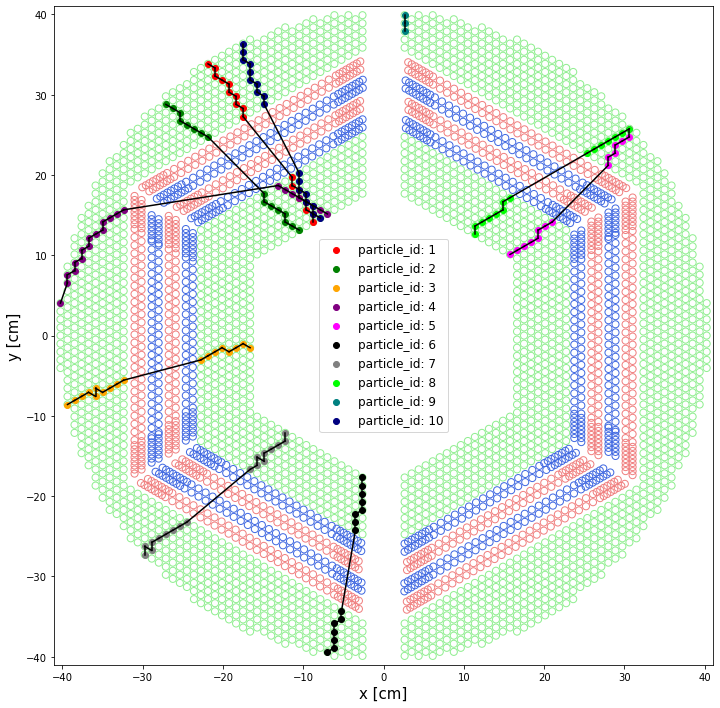

In [29]:
# Method 2: plotting ground truth from edge_idex

plt.close("all")

# cmap = plt.get_cmap('tab20')
cmap = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "magenta",
    "black",
    "gray",
    "lime",
    "teal",
    "navy",
    "maroon",
    "olive",
    "indigo",
    "cyan",
]
# draw detector layout
fig, ax = detector_layout(figsize=(10, 10))

# draw particles
unique_pids = np.unique(pids)
for pid in unique_pids:
    mask = feature_data.pid == pid
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f"particle_id: {pid}")

# draw edges
ax.plot(x[true_edges], y[true_edges], c="k")

# axis params
ax.legend(fontsize=12, loc="best")
fig.tight_layout()
fig.savefig("true_edges_2.pdf")

#### _(4.1.3.) - drawing **true edges** from `edge_index` and `pid` (heuristic?) fields from `feature_data`_

In [30]:
# get PyG data fields
x = feature_data.x
pids = feature_data.pid
e = feature_data.edge_index

In [31]:
# coordinate transform: [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

In [32]:
# get true edges from edge_index and pids
true_edge_mask = pids[e[0]] == pids[e[1]]
true_edges = e[:, true_edge_mask]

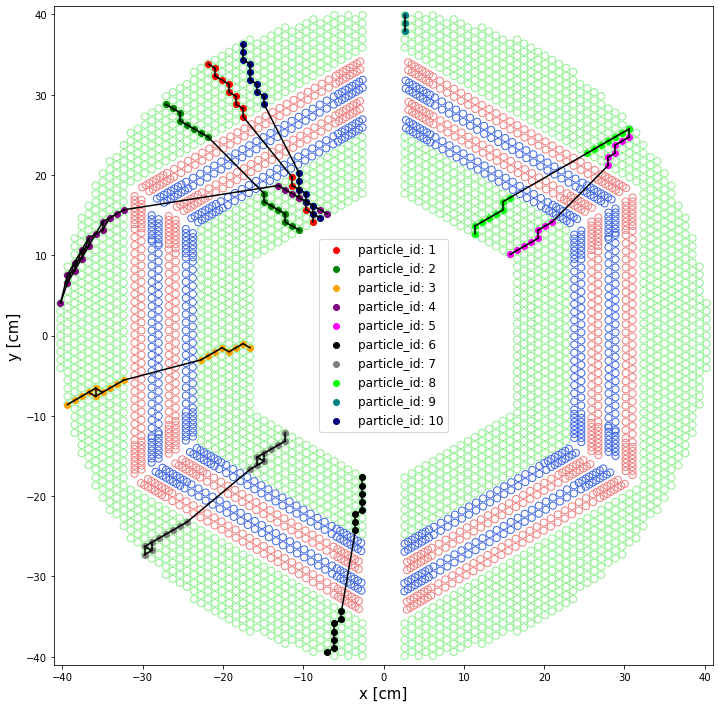

In [33]:
# Method 3: plotting ground truth from edge_idex and pid

plt.close("all")
fig, ax = detector_layout(figsize=(10, 10))

# cmap = plt.get_cmap('tab20')
cmap = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "magenta",
    "black",
    "gray",
    "lime",
    "teal",
    "navy",
    "maroon",
    "olive",
    "indigo",
    "cyan",
]

# particle tracks
unique_pids = np.unique(pids)
for pid in unique_pids:
    mask = feature_data.pid == pid
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f"particle_id: {pid}")

# draw true edges
ax.plot(x[true_edges], y[true_edges], c="k")

# axis params
ax.legend(fontsize=12, loc="best")
fig.tight_layout()
fig.savefig("true_edges_3.pdf")

### _(4.2) - False Edges_

#### _(4.2.1.) - plotting **false edges** from `edge_index` and `y` fields from `feature_data`_

In [34]:
# get PyG data fields
x = feature_data.x
pids = feature_data.pid
e = feature_data.edge_index
y_pid = feature_data.y_pid

In [35]:
# coordinate transform: [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

In [36]:
# get true edges
false_edge_mask = ~(y_pid.bool())  # convert to boolean mask
false_edges = e[:, false_edge_mask]  # filter true edges

In [37]:
false_edges.shape

torch.Size([2, 1451])

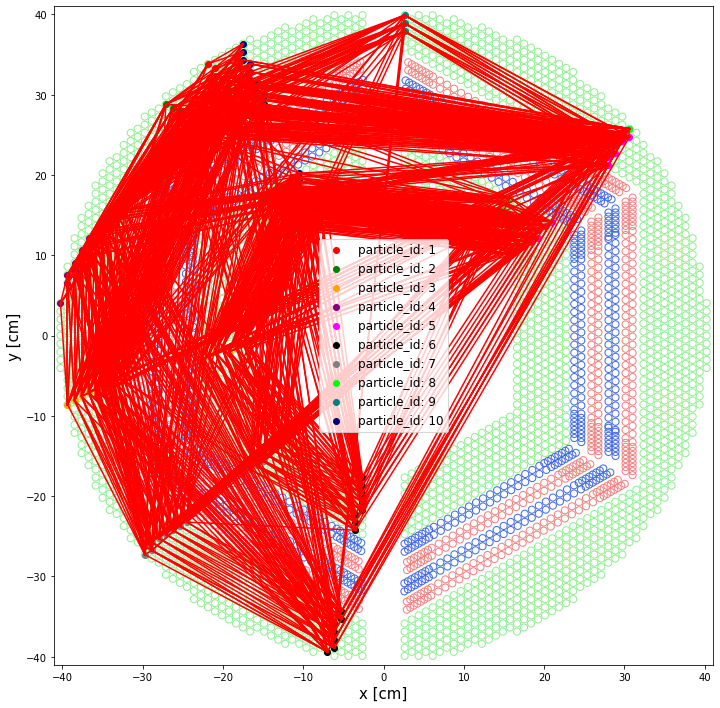

In [38]:
# plotting false edges from edge_idex

plt.close("all")
fig, ax = detector_layout(figsize=(10, 10))

# cmap = plt.get_cmap('tab20')
cmap = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "magenta",
    "black",
    "gray",
    "lime",
    "teal",
    "navy",
    "maroon",
    "olive",
    "indigo",
    "cyan",
]

# particle tracks
unique_pids = np.unique(pids)
for pid in unique_pids:
    mask = feature_data.pid == pid
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f"particle_id: {pid}")

# draw false edges
ax.plot(x[false_edges], y[false_edges], color="r")

# axis params
ax.legend(fontsize=12, loc="best")
fig.tight_layout()
# fig.savefig("false_edges_1.pdf")

#### _(4.2.2.) - plotting **false edges** from `edge_index` and `pid` (heuristic?) fields from `feature_data`_

In [39]:
# get PyG data fields
x = feature_data.x
pids = feature_data.pid
e = feature_data.edge_index

In [40]:
# coordinate transform: [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

In [41]:
# get false edges
false_edges = pids[e[0]] != pids[e[1]]  # alternatively: false_edges = ~true_edges

In [42]:
false_edges.shape

torch.Size([1600])

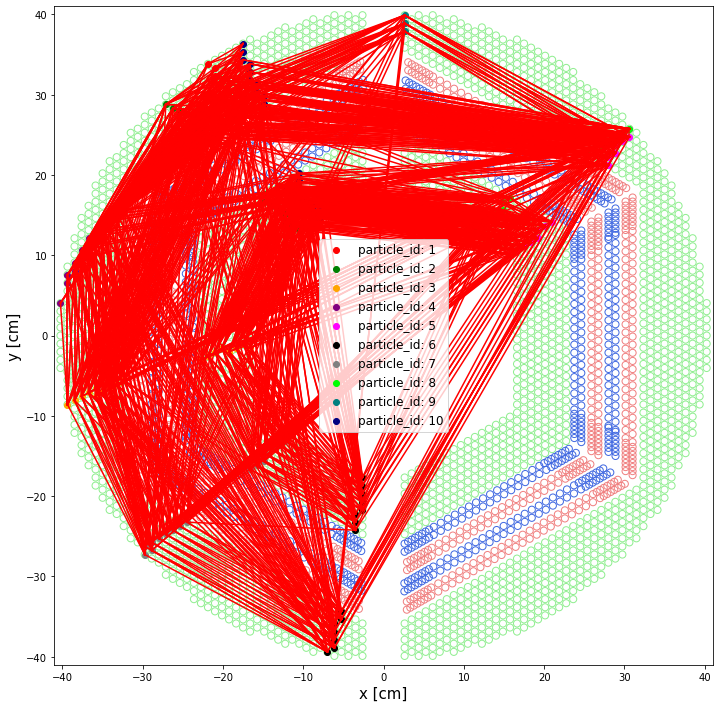

In [43]:
# plotting false edges from edge_idex

plt.close("all")
fig, ax = detector_layout(figsize=(10, 10))

# cmap = plt.get_cmap('tab20')
cmap = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "magenta",
    "black",
    "gray",
    "lime",
    "teal",
    "navy",
    "maroon",
    "olive",
    "indigo",
    "cyan",
]

# particle tracks
unique_pids = np.unique(pids)
for pid in unique_pids:
    mask = feature_data.pid == pid
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f"particle_id: {pid}")

# draw false edges
ax.plot(x[e[:, false_edges]], y[e[:, false_edges]], color="r")

# axis params
ax.legend(fontsize=12, loc="best")
fig.tight_layout()
# fig.savefig("false_edges_2.pdf")

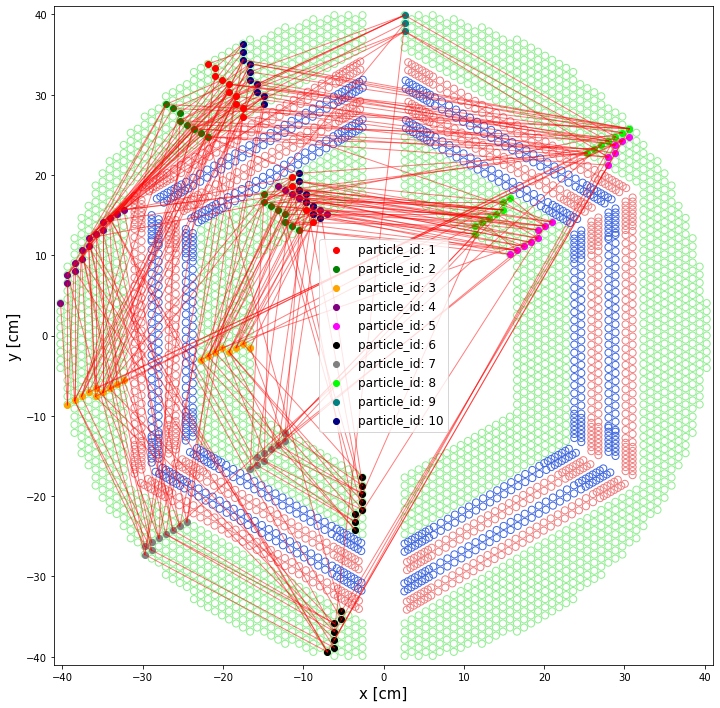

In [44]:
# plotting false edges from edge_idex (thinout)

plt.close("all")
fig, ax = detector_layout(figsize=(10, 10))

# cmap = plt.get_cmap('tab20')
cmap = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "magenta",
    "black",
    "gray",
    "lime",
    "teal",
    "navy",
    "maroon",
    "olive",
    "indigo",
    "cyan",
]

# particle tracks
unique_pids = np.unique(pids)
for pid in unique_pids:
    mask = feature_data.pid == pid
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f"particle_id: {pid}")

# false edges (note: false edges are randomly plotted)
ax.plot(
    x[e[:, false_edges][:, 0:-1:5]],
    y[e[:, false_edges][:, 0:-1:5]],
    color="r",
    alpha=0.5,
    lw=1,
)

# axis params
ax.legend(fontsize=12, loc="best")
fig.tight_layout()
# fig.savefig("false_edges_2_thin.pdf")

### _(4.3) - Input Edges_

- plotting _**input edges**_ from _`edge_idex`_ (all edges) available in _`feature_data`_

In [45]:
# get PyG data fields
x = feature_data.x
pids = feature_data.pid
e = feature_data.edge_index

In [46]:
# coordinate transform: [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

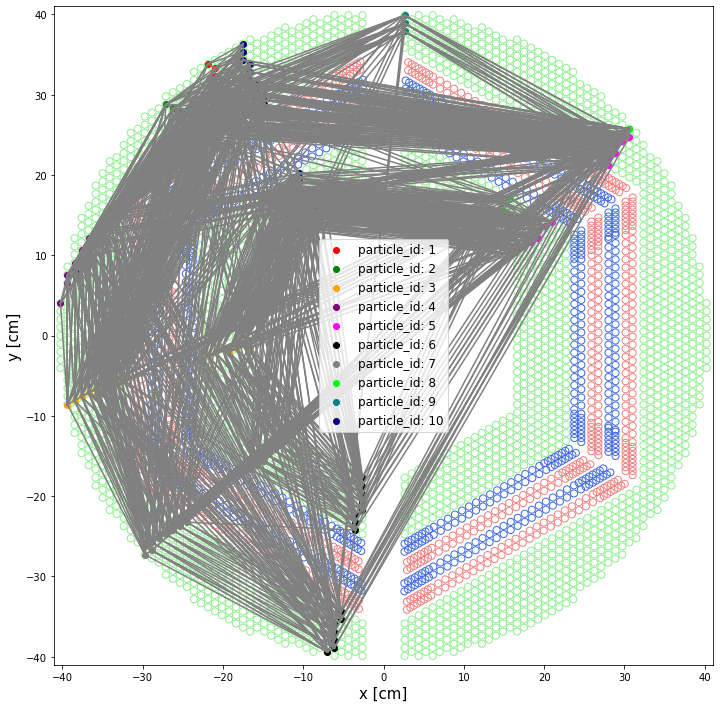

In [47]:
# plotting input edges from edge_index

plt.close("all")
fig, ax = detector_layout(figsize=(10, 10))

# cmap = plt.get_cmap('tab20')
cmap = [
    "blue",
    "red",
    "green",
    "orange",
    "purple",
    "magenta",
    "black",
    "gray",
    "lime",
    "teal",
    "navy",
    "maroon",
    "olive",
    "indigo",
    "cyan",
]

# particle tracks
unique_pids = np.unique(pids)
for pid in unique_pids:
    mask = feature_data.pid == pid
    ax.scatter(x[mask], y[mask], color=cmap[pid], label=f"particle_id: {pid}")

# draw input edges (note: input_edges ~ edge_index)
# for i, (source, target) in enumerate(edge_index.T):
# for (source, target) in e.T:
#    ax.plot([x[source], x[target]], [y[source], y[target]], color='grey')

ax.plot(x[e], y[e], c="grey")

# axis params
ax.legend(fontsize=12, loc="best")
fig.tight_layout()
# fig.savefig("input_edges.pdf")

## _(5) - Plotting Edges (Old)_

- _True Edges (Layerwise, Modulewise, Orderwise)_
- _False Edges (Heuristic Method, Metric Learning)_
- _Input Edges (All True and False together)_

### _(5.1) - Plotting True Edges_

In _feature_data_, we have _`layerwise_true_edges`_, _`modulewise_true_edges`_ and _`edge_index`_ (_a.k.a_ input graph). The _`edge_index`_ contains both _`true`_ and _`false`_ edges. However, we have _`edge_index`_ truth as _`y`_ or _`y_pid`_. So by using _`y_pid==1(0)`_ one can query only _`true (false)`_ edges.

Let's separate true edges:

In [48]:
# get PyG data fields
x = feature_data.x
pids = feature_data.pid
e = feature_data.edge_index

In [49]:
# coordinate transform: [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

In [50]:
# get true edges (same as 4.1.2)
true_edge_mask = torch.where(feature_data.y_pid == 1)[0]
true_edges = e[:, true_edge_mask]

In [51]:
true_edges.shape

torch.Size([2, 149])

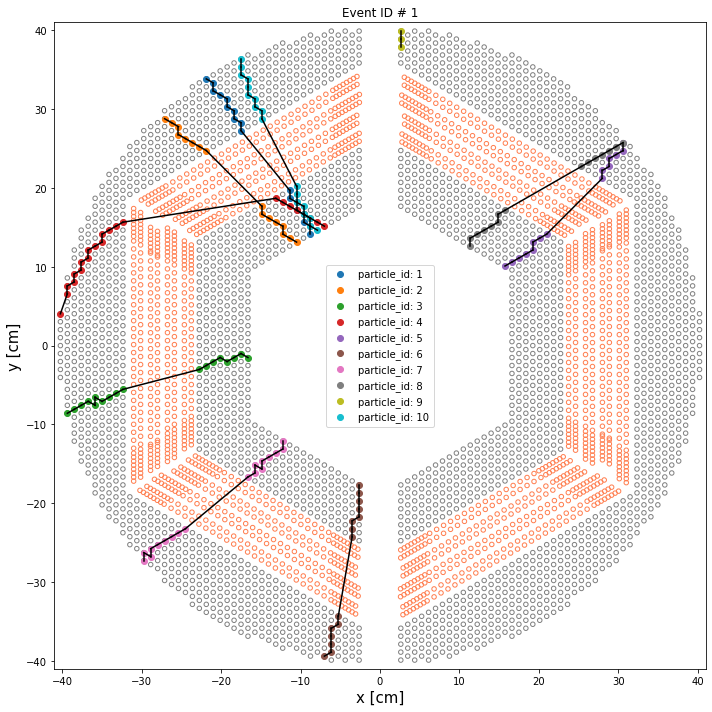

In [52]:
# plotting input_edges
plt.close("all")

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query("skewed==0")
nkw = det.query("skewed==1")  # one may look for +ve/-ve polarity
ax.scatter(skw.x.values, skw.y.values, s=20, facecolors="none", edgecolors="grey")
ax.scatter(nkw.x.values, nkw.y.values, s=20, facecolors="none", edgecolors="coral")

# particle tracks
unique_pids = np.unique(pids)
for pid in unique_pids:
    mask = feature_data.pid == pid
    ax.scatter(x[mask], y[mask], label="particle_id: %d" % pid)

# true edges
for iedge in range(true_edges.shape[1]):
    ptx1 = x[true_edges[0][iedge]]
    ptx2 = x[true_edges[1][iedge]]
    pty1 = y[true_edges[0][iedge]]
    pty2 = y[true_edges[1][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color="k")

# plotting params
ax.set_title("Event ID # %d" % event_id)
ax.set_xlabel("x [cm]", fontsize=15)
ax.set_ylabel("y [cm]", fontsize=15)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc="best")
fig.tight_layout()
# fig.savefig("true_edges.png")

### _(5.2) - Plotting False Edges_

In _feature_data_, we have _`layerwise_true_edges`_, _`modulewise_true_edges`_ and _`edge_index`_ (_a.k.a_ input graph). The _`edge_index`_ contains both _`true`_ and _`false`_ edges. However, we have _`edge_index`_ truth as _`y`_ or _`y_pid`_. So by using _`y_pid==1(0)`_ one can query only _`true (false)`_ edges.

Let's separate false edges:

In [53]:
# get PyG data fields
x = feature_data.x
pids = feature_data.pid
e = feature_data.edge_index

In [54]:
# coordinate transform: [r, phi] to [x, y]
x, y = polar_to_cartesian(r=x[:, 0], phi=x[:, 1])

In [55]:
# get true edges (same as 4.2.1)
false_edge_mask = torch.where(feature_data.y_pid == 0)[0]
false_edges = e[:, false_edge_mask]

In [56]:
false_edges.shape

torch.Size([2, 1451])

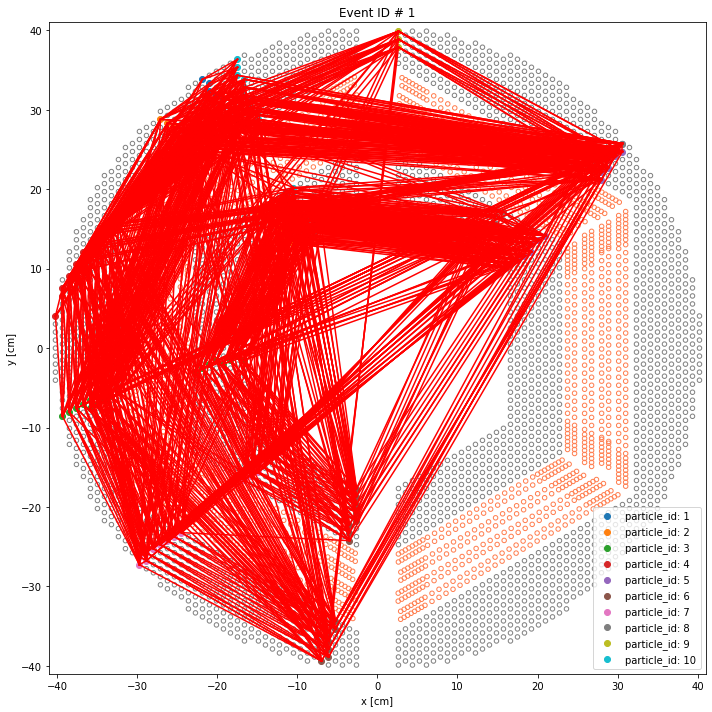

In [57]:
# plotting input_edges
plt.close("all")

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query("skewed==0")
nkw = det.query("skewed==1")  # one may look for +ve/-ve polarity
ax.scatter(skw.x.values, skw.y.values, s=20, facecolors="none", edgecolors="grey")
ax.scatter(nkw.x.values, nkw.y.values, s=20, facecolors="none", edgecolors="coral")

# particle tracks
unique_pids = np.unique(pids)
for pid in unique_pids:
    mask = feature_data.pid == pid
    ax.scatter(x[mask], y[mask], label="particle_id: %d" % pid)

# input edges
for iedge in range(false_edges.shape[1]):
    # for iedge in range(56):
    ptx1 = x[false_edges[0][iedge]]
    ptx2 = x[false_edges[1][iedge]]
    pty1 = y[false_edges[0][iedge]]
    pty2 = y[false_edges[1][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color="r")

# plotting params
ax.set_title("Event ID # %d" % event_id)
ax.set_xlabel("x [cm]", fontsize=10)
ax.set_ylabel("y [cm]", fontsize=10)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc="best")
fig.tight_layout()
# fig.savefig("false_edges.png")

### _(5.3) - Plotting Input Edges_

In [58]:
# get all edges
input_edges = feature_data.edge_index

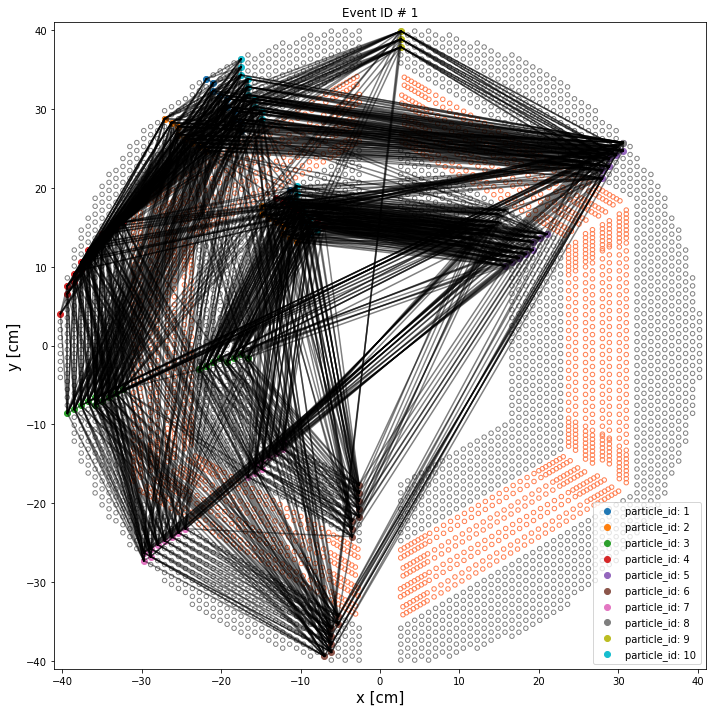

In [59]:
# plotting input edges
plt.close("all")

# init subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

# draw detector layout
det = pd.read_csv("src/stt.csv")
skw = det.query("skewed==0")
nkw = det.query("skewed==1")  # one may look for +ve/-ve polarity
ax.scatter(skw.x.values, skw.y.values, s=20, facecolors="none", edgecolors="grey")
ax.scatter(nkw.x.values, nkw.y.values, s=20, facecolors="none", edgecolors="coral")

# draw particle tracks
unique_pids = np.unique(pids)
for pid in unique_pids:
    mask = feature_data.pid == pid
    ax.scatter(x[mask], y[mask], label="particle_id: %d" % pid)

# draw input edges
for iedge in range(input_edges.shape[1]):
    ptx1 = x[input_edges[0][iedge]]
    ptx2 = x[input_edges[1][iedge]]
    pty1 = y[input_edges[0][iedge]]
    pty2 = y[input_edges[1][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color="k", alpha=0.5, lw=1.5)

# plotting params
ax.set_title("Event ID # %d" % event_id)
ax.set_xlabel("x [cm]", fontsize=15)
ax.set_ylabel("y [cm]", fontsize=15)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=10, loc="best")
fig.tight_layout()
# fig.savefig("input_edges.png")

## _(6) - Plot Ture or False Edges_

- code from _`notebooks/example_gnn.ipynb`_.

- True Edges

- False Edges